In [55]:
#General import
import pandas as pd
import janitor as jn
import pandas_profiling
import numpy as np
import xgboost as xgb
import os
import pydotplus

#sklearn import
from sklearn import ensemble,preprocessing,tree, impute
from sklearn.metrics import average_precision_score,auc, confusion_matrix,roc_auc_score,roc_curve, precision_score, confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,KFold, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#missingno import
import missingno as msno

#mlxtend import
from mlxtend.classifier import StackingClassifier

##Yellowbirck import
from yellowbrick.classifier import DiscriminationThreshold,ClassPredictionError,ClassBalance,PrecisionRecallCurve,ConfusionMatrix, ROCAUC, ClassificationReport
from yellowbrick.features import JointPlotVisualizer,Rank2D, RadViz
from yellowbrick.model_selection import LearningCurve, FeatureImportances, ValidationCurve

from io import StringIO

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
#Get train and test absolute path
CURRENT_DIR = os.getcwd()
DATA_DIR = 'data'
TRAIN_FILENAME ='train.csv'
TEST_FILENAME = 'test.csv'
train_path = os.path.join(CURRENT_DIR,DATA_DIR,TRAIN_FILENAME)
test_path = os.path.join(CURRENT_DIR,DATA_DIR,TEST_FILENAME)

In [3]:
#Load train.csv and test.csv as pandas Dataframe
train = pd.read_csv(train_path, index_col='PassengerId')
test = pd.read_csv(test_path, index_col='PassengerId')

In [4]:
train = jn.clean_names(train)
test = jn.clean_names(test)

In [5]:
train.dtypes == object

survived    False
pclass      False
name         True
sex          True
age         False
sibsp       False
parch       False
ticket       True
fare        False
cabin        True
embarked     True
dtype: bool

In [6]:
y = train.survived

In [7]:
#Encode Categorical features and removed unecessary ones
cat_df= pd.get_dummies(train[["sex","embarked"]],drop_first=True)
X = pd.concat([train,cat_df], axis = 1)
X = X.drop(columns=["survived","name","ticket","cabin","embarked","sex"])

In [8]:
#Impute training
num_cols = ['pclass','age','sibsp','parch','fare','sex_male']
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(X[num_cols])
X.loc[:,num_cols] = imputed

In [9]:
X_train, X_valid, y_train, y_valid =  train_test_split(X,y,test_size=0.3, random_state=42)

In [10]:
#Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train,y_train)
lr.score(X_valid,y_valid)

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8134328358208955

In [11]:
#GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)
nb.score(X_valid,y_valid)

0.7985074626865671

In [12]:
# SVC
# To get higher score,features should be normalized
svc = SVC(random_state=42,probability=True)
svc.fit(X_train,y_train)
svc.score(X_valid,y_valid)

0.6567164179104478

In [13]:
#KNeighboors
kn = KNeighborsClassifier()
kn.fit(X_train,y_train)
kn.score(X_valid,y_valid)

0.6977611940298507

In [14]:
#DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt.score(X_valid,y_valid)

0.75

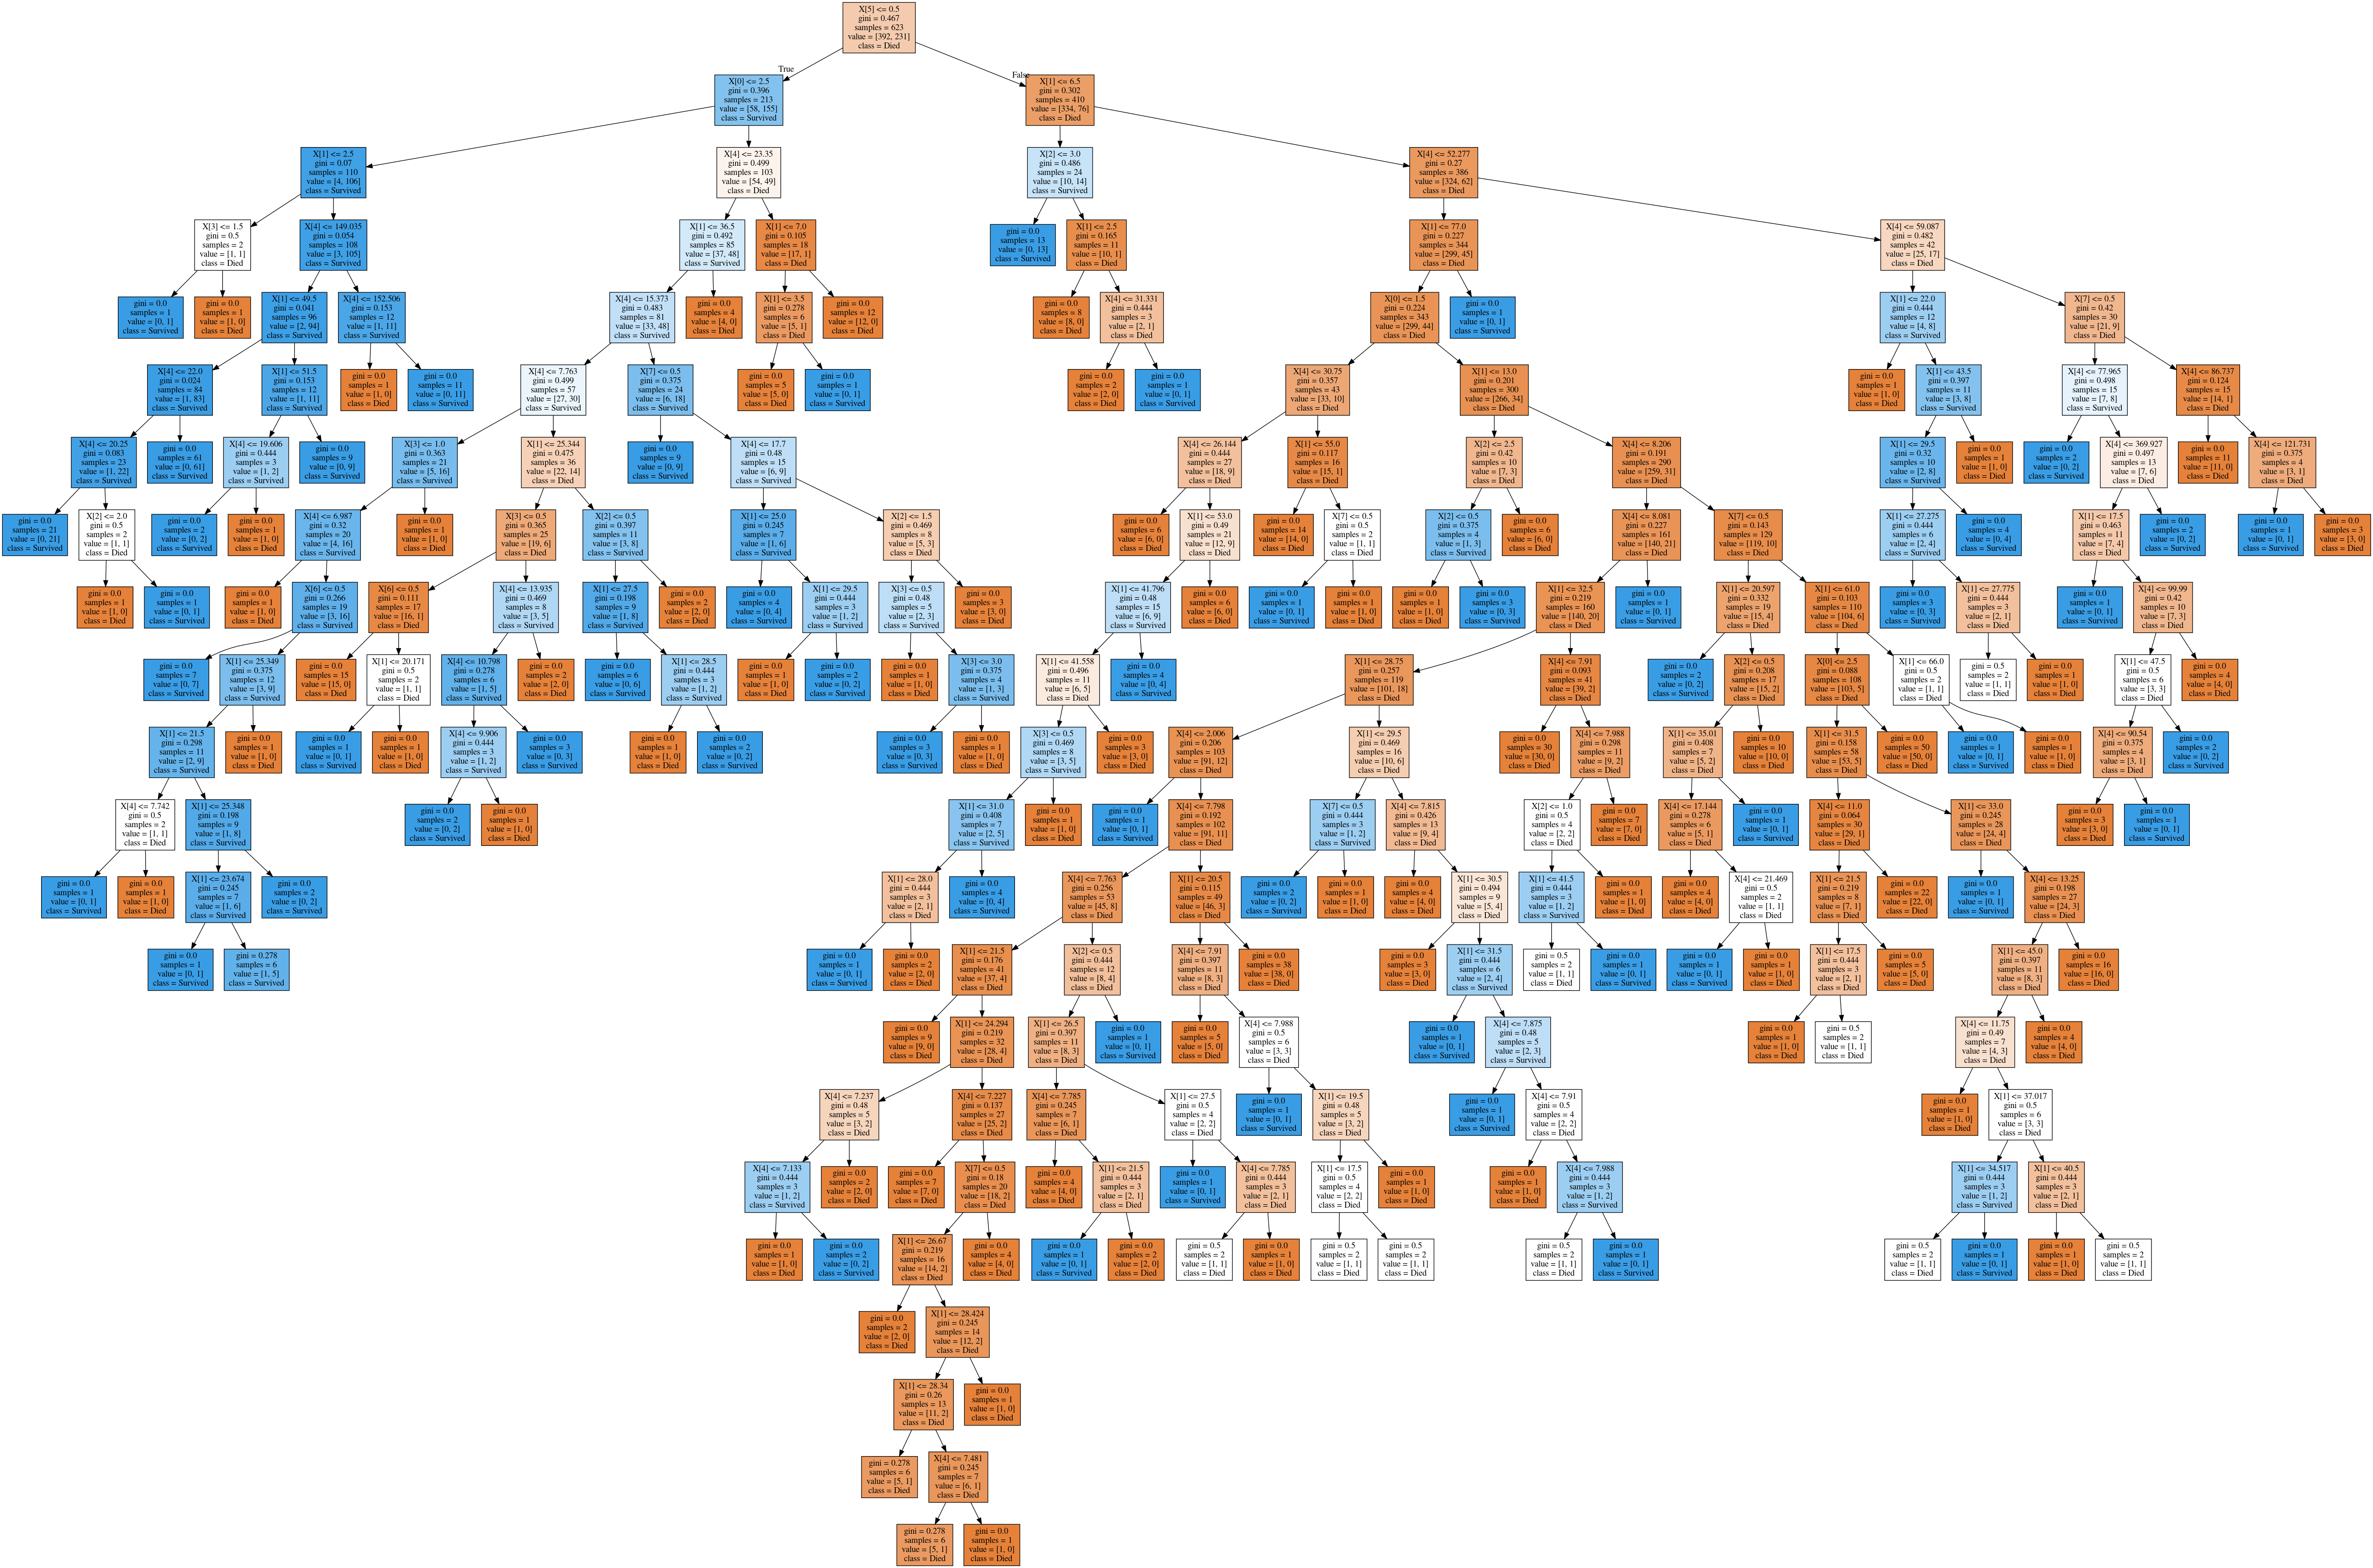

In [15]:
#Show Decision Treee graphicaly
dot_data = StringIO()
tree.export_graphviz(
dt,
out_file=dot_data,
class_names=["Died","Survived"],
filled=True)
g = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(g.create_png())

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


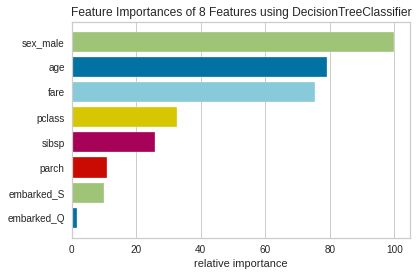

In [16]:
fig, ax =plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(dt)
fi_viz.fit(X,y)
fi_viz.poof()

In [17]:
#RandomForrest
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_valid,y_valid)

0.7686567164179104

In [18]:
for col, val in sorted(zip(X.columns,rf.feature_importances_), key = lambda x: x[1], reverse=True)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.271
fare           0.265
sex_male       0.242
pclass         0.086
sibsp          0.054


In [19]:
#XGB
xgb_class = xgb.XGBClassifier(random_state = 42)
xgb_class.fit(X_train,y_train, early_stopping_rounds =10,eval_set=[(X_valid,y_valid)])
xgb_class.score(X_valid,y_valid)

[0]	validation_0-error:0.18284
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.20522
[2]	validation_0-error:0.20896
[3]	validation_0-error:0.20522
[4]	validation_0-error:0.20522
[5]	validation_0-error:0.20896
[6]	validation_0-error:0.19776
[7]	validation_0-error:0.19403
[8]	validation_0-error:0.22015
[9]	validation_0-error:0.21642
[10]	validation_0-error:0.21642
Stopping. Best iteration:
[0]	validation_0-error:0.18284



0.8171641791044776

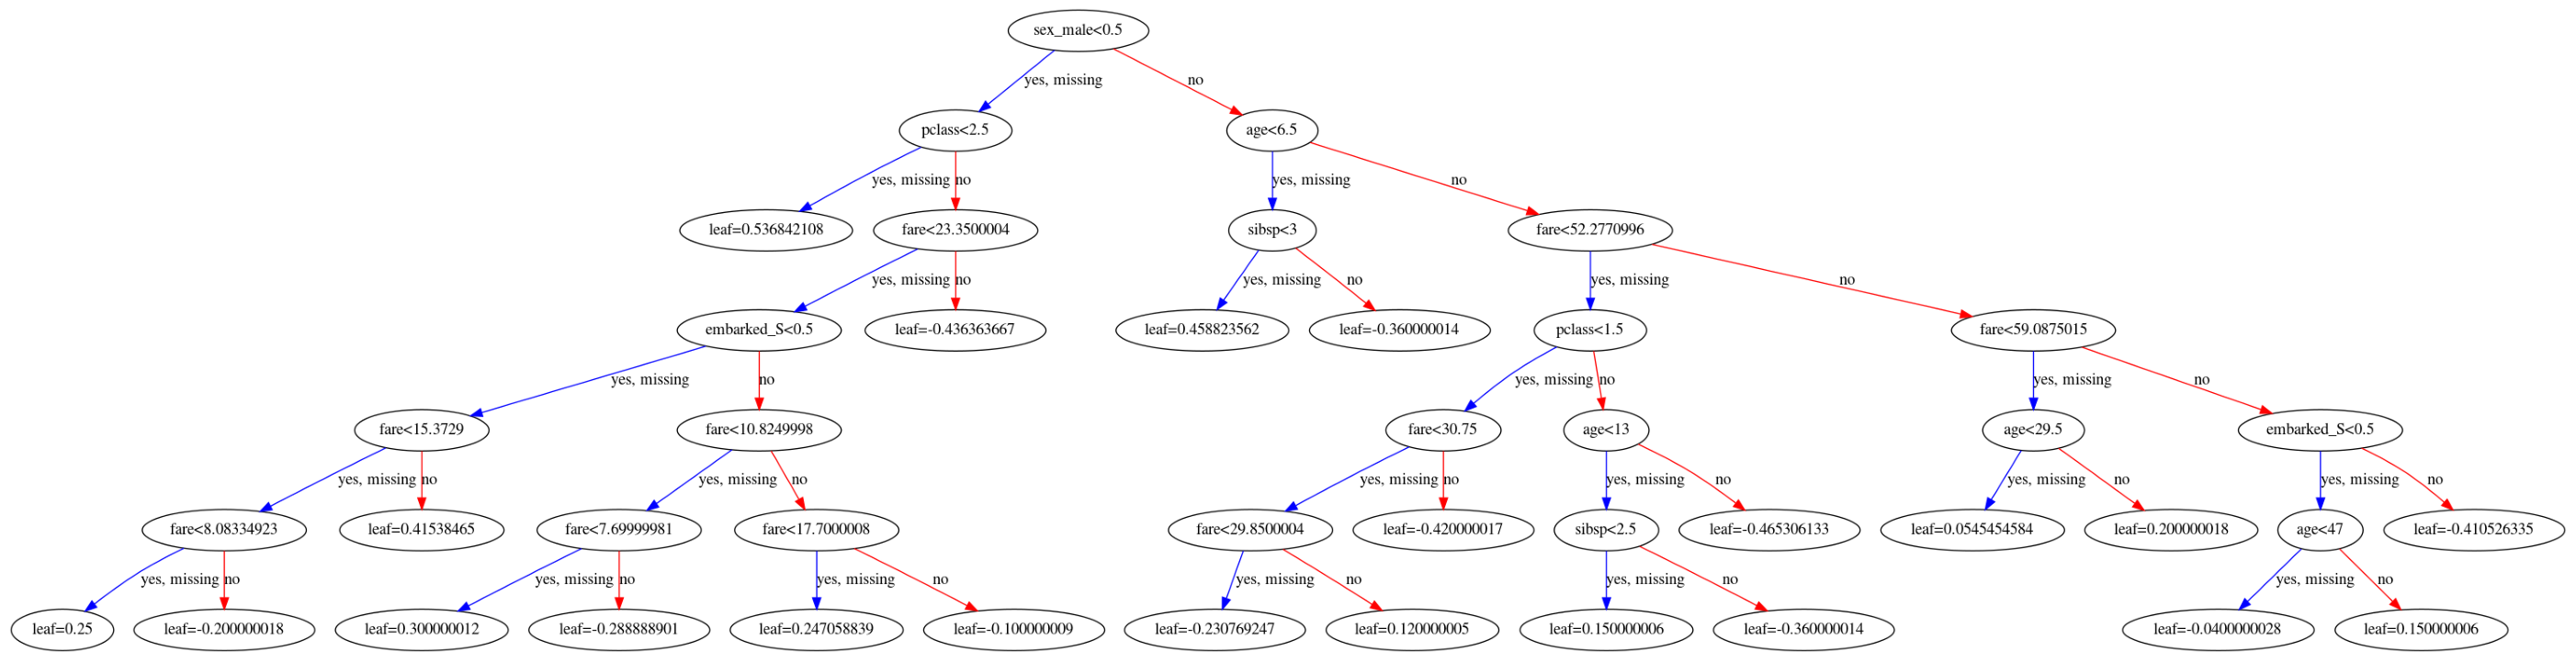

In [20]:
fig,ax = plt.subplots(figsize=(50,40))
xgb.plot_tree(xgb_class,ax=ax,num_trees=0)
fig.savefig("mlr-xgb.png")

In [ ]:
#Validation Curve
fig,ax = plt.subplots(figsize=(6,4))
vc_viz = ValidationCurve(RandomForestClassifier(n_estimators=100),
                         param_name='max_depth',
                         param_range=np.arange(1,11),
                         cv=10,
                         n_jobs=-1
                        )
vc_viz.fit(X_train,y_train)
vc_viz.poof()

In [ ]:
#Learning Curve
fig,ax = plt.subplots(figsize=(6,4))
lc3_viz = LearningCurve(RandomForestClassifier(n_estimators=100),
                       cv=10)
lc3_viz.fit(X_train,y_train)
lc3_viz.poof()

In [ ]:
#Confusion Matrix
y_predict = rf.predict(X_valid)
pd.DataFrame(confusion_matrix(y_valid,y_predict),
            columns=["Predict died","Predict Survive"],
            index = ["True Death","True Survive"])

In [ ]:
#YellowBrick Confusion Matrix
mapping = {0:"died",1:"survived"}
fig,ax = plt.subplots(figsize=(6,4))
cm_viz = ConfusionMatrix(
    rf,
    classes=["died,survived"],
    encoder = mapping
)
cm_viz.score(X_valid,y_valid)
cm_viz.poof()

In [ ]:
#Accuracy metric
y_pred = rf.predict(X_valid)
accuracy_score(y_valid,y_pred)

In [ ]:
#Recall metric
recall_score(y_valid,y_pred)

In [ ]:
#Precision metric
precision_score(y_valid,y_pred)

In [ ]:
#F1 metric
f1_score(y_valid,y_pred)

In [ ]:
#Classification Report
fig,ax = plt.subplots(figsize=(6,3))
cm_viz = ClassificationReport(rf,
                             classes = ["died","survived"],
                              encoder=mapping)
cm_viz.score(X_valid,y_valid)
cm_viz.poof()

In [ ]:
#ROC
roc_auc_score(y_valid,y_predict)

In [ ]:
#ROC with Yellowbrick
fig,ax = plt.subplots(figsize=(6,6))
roc_viz = ROCAUC(rf)
roc_viz.score(X_valid,y_valid)
roc_viz.poof()

In [ ]:
#Precision-Recall curve
average_precision_score(y_valid,y_predict)

In [ ]:
#Yellowbrick Precision-Recall curve
fig,ax = plt.subplots(figsize=(6,4))
viz = PrecisionRecallCurve(RandomForestClassifier(max_depth=3))
viz.fit(X_train,y_train)
viz.score(X_valid,y_valid)
viz.poof()


In [ ]:
#Class imbalance
fig,ax = plt.subplots(figsize=(6,6))
cb_viz = ClassBalance(labels = ["Died","Survived"])
cb_viz.fit(y_valid)
cb_viz.poof()

In [ ]:
#Class prediction Error
fig,ax = plt.subplots(figsize=(6,6))
cpe_viz = ClassPredictionError(rf,labels = ["Died","Survived"])
cpe_viz.score(X_valid,y_valid)
cpe_viz.poof()

In [ ]:
#Discrimination threshold
fig,ax = plt.subplots(figsize=(6,5))
dt_viz = DiscriminationThreshold(rf)
dt_viz.fit(X_train,y_train)
dt_viz.poof()

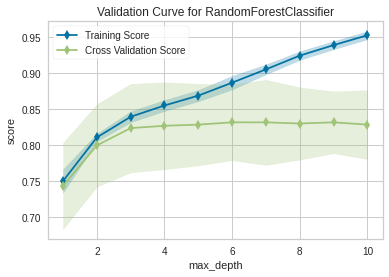

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


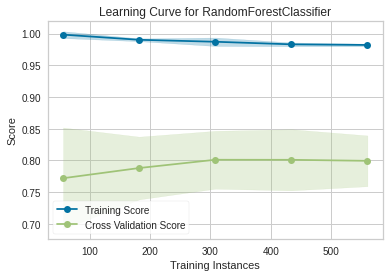

In [24]:
#Learning Curve
fig,ax = plt.subplots(figsize=(6,4))
lc3_viz = LearningCurve(RandomForestClassifier(n_estimators=100),
                       cv=10)
lc3_viz.fit(X_train,y_train)
lc3_viz.poof()

In [27]:
#Confusion Matrix
y_predict = rf.predict(X_valid)
pd.DataFrame(confusion_matrix(y_valid,y_predict),
            columns=["Predict died","Predict Survive"],
            index = ["True Death","True Survive"])

Predict died  Predict Survive
True Death             128               29
True Survive            33               78

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/yellowbrick/classifier/base.py:249: YellowbrickWarning: both classes and encoder specified, using encoder
  warnings.warn(
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/yellowbrick/classifier/base.py:249: YellowbrickWarning: both classes and encoder specified, using encoder
  warnings.warn(
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/yellowbrick/classifie

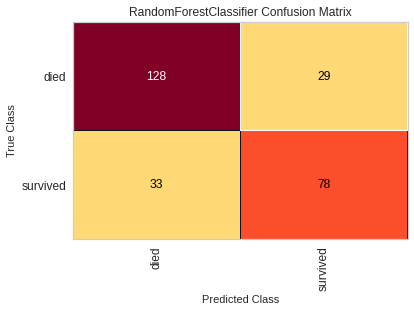

In [29]:
#YellowBrick Confusion Matrix
mapping = {0:"died",1:"survived"}
fig,ax = plt.subplots(figsize=(6,4))
cm_viz = ConfusionMatrix(
    rf,
    classes=["died,survived"],
    encoder = mapping
)
cm_viz.score(X_valid,y_valid)
cm_viz.poof()

In [32]:
#Accuracy metric
y_pred = rf.predict(X_valid)
accuracy_score(y_valid,y_pred)

0.7686567164179104

In [33]:
#Recall metric
recall_score(y_valid,y_pred)

0.7027027027027027

In [34]:
#Precision metric
precision_score(y_valid,y_pred)

0.7289719626168224

In [35]:
#F1 metric
f1_score(y_valid,y_pred)

0.7155963302752293

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/yellowbrick/classifier/base.py:249: YellowbrickWarning: both classes and encoder specified, using encoder
  warnings.warn(
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


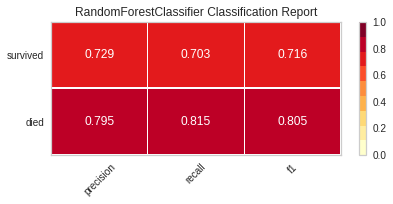

In [41]:
#Classification Report
fig,ax = plt.subplots(figsize=(6,3))
cm_viz = ClassificationReport(rf,
                             classes = ["died","survived"],
                              encoder=mapping)
cm_viz.score(X_valid,y_valid)
cm_viz.poof()

In [43]:
#ROC
roc_auc_score(y_valid,y_predict)

0.7589946634532622

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


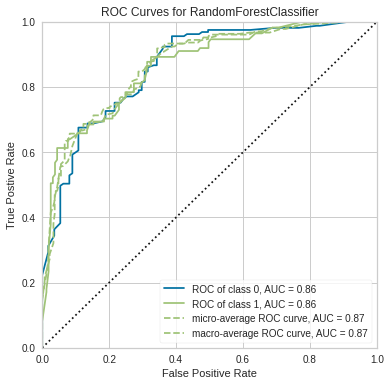

In [45]:
#ROC with Yellowbrick
fig,ax = plt.subplots(figsize=(6,6))
roc_viz = ROCAUC(rf)
roc_viz.score(X_valid,y_valid)
roc_viz.poof()

In [47]:
#Precision-Recall curve
average_precision_score(y_valid,y_predict)

0.6353848966835436

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


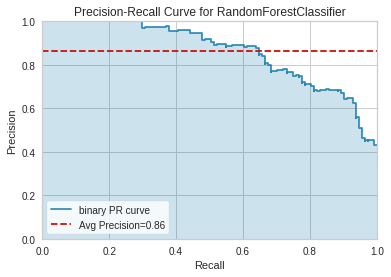

In [49]:
#Yellowbrick Precision-Recall curve
fig,ax = plt.subplots(figsize=(6,4))
viz = PrecisionRecallCurve(RandomForestClassifier(max_depth=3))
viz.fit(X_train,y_train)
viz.score(X_valid,y_valid)
viz.poof()


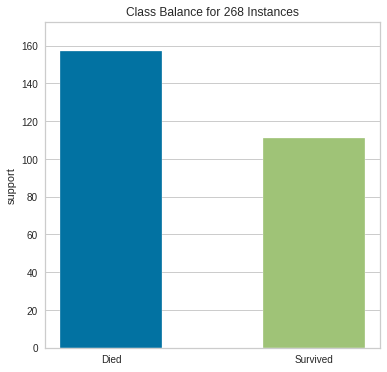

In [52]:
#Class imbalance
fig,ax = plt.subplots(figsize=(6,6))
cb_viz = ClassBalance(labels = ["Died","Survived"])
cb_viz.fit(y_valid)
cb_viz.poof()

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


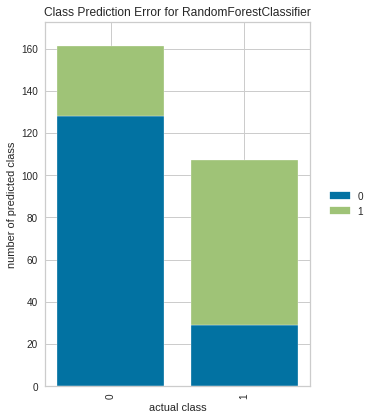

In [54]:
#Class prediction Error
fig,ax = plt.subplots(figsize=(6,6))
cpe_viz = ClassPredictionError(rf,labels = ["Died","Survived"])
cpe_viz.score(X_valid,y_valid)
cpe_viz.poof()

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Func

/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/home/christophe/anaconda3/envs/titanic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_i

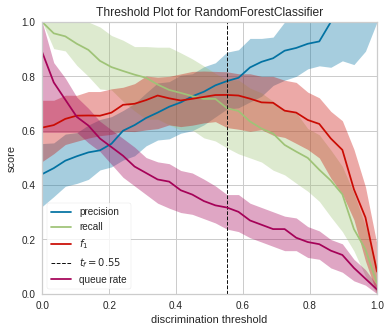

In [56]:
#Discrimination threshold
fig,ax = plt.subplots(figsize=(6,5))
dt_viz = DiscriminationThreshold(rf)
dt_viz.fit(X_train,y_train)
dt_viz.poof()